# Part 2: Time Series Forecast with ARIMA (2 days) 📈

Welcome to the second part of your journey towards mastering the art of forecasting with ARIMA models. We will demystify ARIMA models, beginning with its foundational principles - autoregression, differencing, moving average. Using the same dataset as in Part 1, you will fit different models and assess their quality in order to compare them. You will also learn the different way of performing train/test splits and cross-validation in the context of time series!

In this notebook, we will cover the following concepts:
- Train / Test splitting for time series
- Naive forecasting models
- ARIMA and SARIMA models
- Cross-Validation for time series

**Objectives**
- Get to use few prediction models
- Understand Cross-Validation in the context of Time Series

**Ressources**

AR, MA, ARIMA :

- https://www.youtube.com/watch?v=Mc6sBAUdDP4&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=zNLG8tsA_Go&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=dXND1OEBABI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=7

ACF & PACF :

- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Métriques :

- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

Cross-validation :

- https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
- https://robjhyndman.com/hyndsight/tscv/

Forecasting: Principles and Practice livre (Rob Hyndman) :

- https://otexts.com/fpp2/
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://otexts.com/fpp2/transformations.html
- https://otexts.com/fpp2/seasonal-arima.html

Documentation de Pmdarima:

- http://alkaline-ml.com/pmdarima/


**Required librairies**
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima
- [ ] sktime

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import sktime as sk

# A bit of theory, again 😁

The ARMA (AutoRegressive Moving Average) model is suitable for predicting any time series whose value $Y$ at time $t$ can be explained by previous values and previous perturbations (noise).

Before specifying what a dataset is according to the ARIMA model, let's specify a dataset according to the conditions :  

- **Autoregressive**: the model predicts the variable $Y$ at time $t$, denoted $Y_t$, from previous values of $Y$ according to a linear regression model, i.e. $Y_{t-1}, Y_{t-2}, ..., Y_0$. Let $p$ denote the number of components used to predict $Y_t$, with

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, with $\varepsilon_t$ a perturbation, and c a constant.

- **Moving average**: a model where the data are the result of the moving average of order $q$. The value $Y_t$ can be expressed using the perturbation at time $t$ and its previous values:

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, with $\mu$ a constant.

Any ARMA model is the combination of the *AR* and *MA* conditions, i.e. it is autoregressive and its noise follows a moving average. Let :

> $Y_t = c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

or :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ with $\varepsilon_t$ the error of the autoregressive model at time $t$.

The model is optimized using the least-squares method.

An ARMA model is suitable for stationary data sets, i.e. with a fixed mean and standard deviation over time. Such data are rarely observed. Many time series datasets show trends in the mean or seasonal patterns. To do this, the problem must first be stationarized. As we saw before, this can be done by differencing the data, apply a model, and then performing the reverse operation: **integration**. An **ARIMA** model is said to be :

- **integrated**: when the data set can be corrected by running the model on $Y'_t = Y_t - Y_{t-1}$ for a correction of order 1 (d=1), or $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ for a correction of order 2 (d=2), etc...  We note $d$ the order of *correction by integration* to suppress polynomial tendencies of order $d$, with:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


ARIMA models are often denoted: ARIMA(p, d, q), or **ARIMA(2, 1, 1)** means :
- an autoregressive model of order 2,
- on data integrated 1 times,
- with a moving average of order 1.

# 1. Train / Test Splitting

Because the temporal order is important in time series, we cannot perform a random train/test split. Rather, we can use the most recent data (e.g. the last year) as the test set!

**TODO**
- Explain why train/test splitting can be a challenge for time series
- Write a function to split the dataset into a train and test set
- Use the function to split the airline passengers dataset, keeping the last twelve months as a test set
- Plot the train and test set in different colors

In [3]:
from sktime.datasets import load_airline

# Load dataset
airline = load_airline()

# Clean & Adjust the data
airline = airline.dropna()
airline_adj = airline / airline.index.days_in_month

In [4]:
airline_adj.sort_index()

Period
1949-01     3.612903
1949-02     4.214286
1949-03     4.258065
1949-04     4.300000
1949-05     3.903226
             ...    
1960-08    19.548387
1960-09    16.933333
1960-10    14.870968
1960-11    13.000000
1960-12    13.935484
Freq: M, Length: 144, dtype: float64

In [5]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    df=data.copy()
    df= df.sort_index() 

    
    
    train_ind = int(len(df)-split_date)
    train = df[:train_ind]
    test = df[train_ind:]
    
    
    
    return train, test


<class 'pandas.core.series.Series'>
PeriodIndex: 108 entries, 1949-01 to 1957-12
Freq: M
Series name: None
Non-Null Count  Dtype  
--------------  -----  
108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB
Jeu de données Train : None
<class 'pandas.core.series.Series'>
PeriodIndex: 36 entries, 1958-01 to 1960-12
Freq: M
Series name: None
Non-Null Count  Dtype  
--------------  -----  
36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes
Jeu de données Test : None


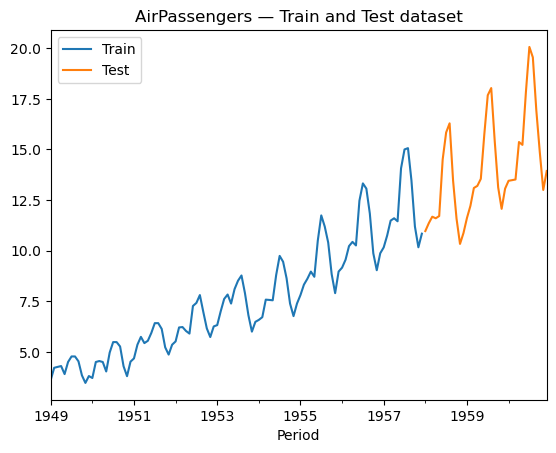

In [6]:
from sktime.utils.plotting import plot_series

# Hold back the last three years as a TEST set
train,test=ts_train_test_split(airline_adj,(3*12)) ### les 3 dernières années * nb de mois

# Check train and test sizes are what we expect
print(f'Jeu de données Train :', train.info())

print(f'Jeu de données Test :', test.info())

# Train and test Dataset
train.plot(label="Train")
plt.title("AirPassengers — Train and Test dataset")
plt.xlim(1949,1960)
test.plot(label="Test")
plt.legend()


# 2. Naive Forecast

We need a baseline (as always!) to know if our more complex models are any use! Given the strong seasonal component that was confirmed by the seasonal decomposition we made earlier, it may be a good idea to use a **seasonal naive** forecasting method. This model takes the value from the same period in the previous season (in this case the same month last year). This is part of the Carry-Forward-Previous-Values' family of **naive** forecasting methods. In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words, we have yearly data so we just take the value from the same month last year.

In [7]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series


### 2.1 Fit a Naive Forecaster

**TODO**
- Fit a Naive and Seasonal Naive forecaster to the train data, and show the predictions along with the test data.
- Plot the residuals using Seaborn's `displot()`, `regplot()` and `residplot()` functions.

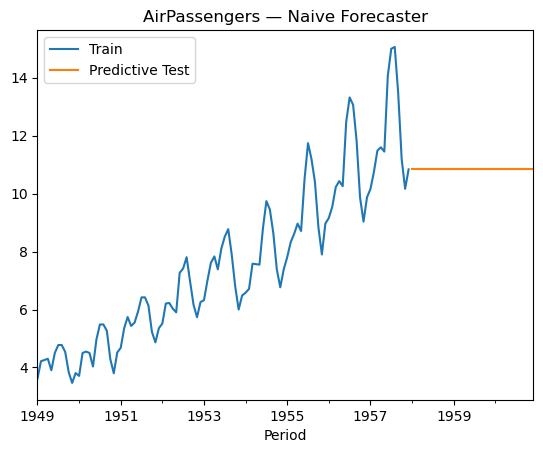

In [8]:
HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

# Your code for the Naive Forecaster
forecaster=NaiveForecaster(strategy="last") ### ou strategy = "mean" ou "last"
forecaster.fit(train)
TestPred=forecaster.predict(fh=fh)

# Train and test Dataset
train.plot(label="Train")
plt.title("AirPassengers — Naive Forecaster")
plt.xlim(1949,1960)
TestPred.plot(label="Predictive Test")
plt.legend()


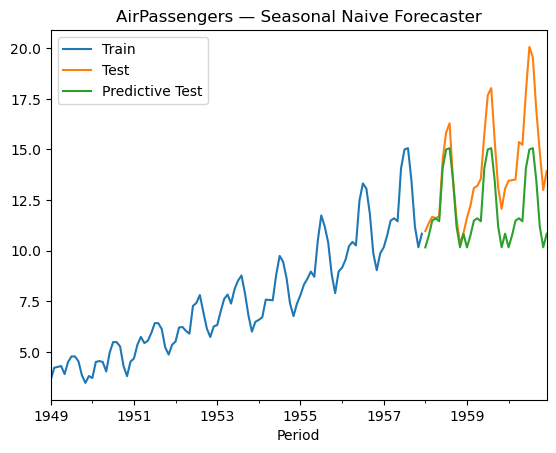

In [9]:
# Your code for the Seasonal Naive Forecaster
forecasterSea=NaiveForecaster(strategy="last",sp=12) ### seasonal periodicity =12 mois
forecasterSea.fit(train)
TestPredSea=forecasterSea.predict(fh=fh)

# Train and test Dataset
train.plot(label="Train")
test.plot(label="Test")
plt.title("AirPassengers — Seasonal Naive Forecaster")
plt.xlim(1949,1960)
TestPredSea.plot(label="Predictive Test")
plt.legend()



In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    mape = np.mean(np.abs((y_true - y_pred)/y_true)*100)
    return mape



def root_mean_square_error(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))
    return rmse

In [11]:
mean_absolute_percentage_error(test,TestPredSea)
mean_absolute_percentage_error(test,TestPred)

20.953578466331987

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

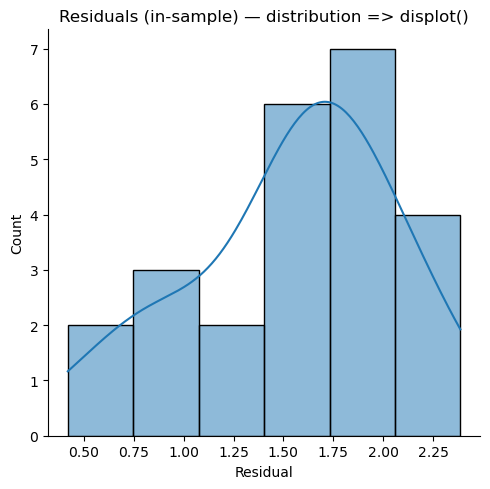

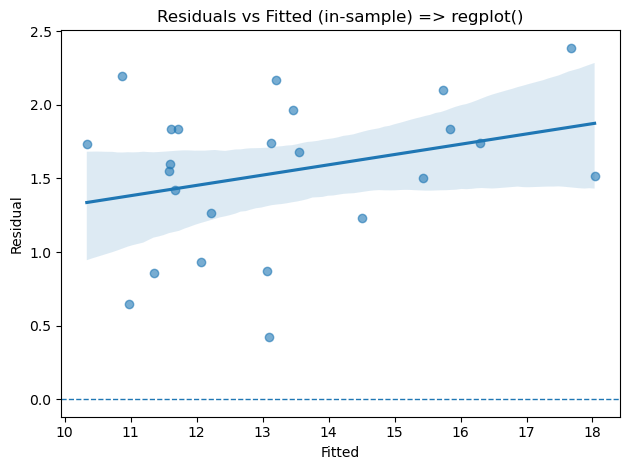

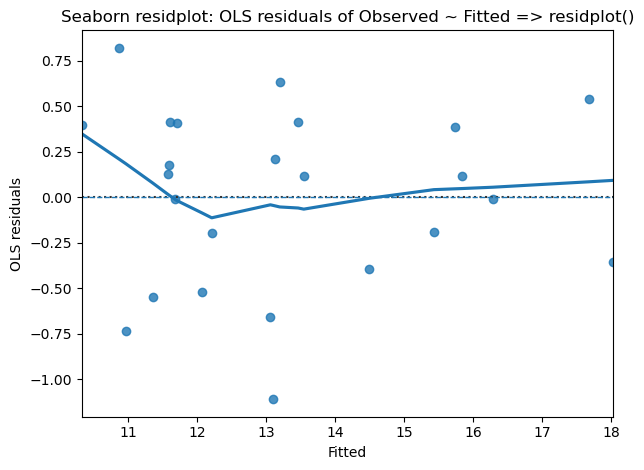

In [12]:
# Your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

####### Résidus de Forecaster => Modèle Naive

# 0) Fitted in-sample + résidus
try:
    fitted_in = forecaster.predict_in_sample()
except Exception:
    fitted_in = test.shift(12)
fitted_in.name = "Fitted (in-sample)"

# Aligner, supprimer NaN
common_idx = test.index.intersection(fitted_in.index)
y_obs  = test.loc[common_idx]
y_fit  = fitted_in.loc[common_idx]
resid  = (y_obs - y_fit)
resid.name = "Residuals (in-sample)"

# 1) Distribution des résidus — displot
sns.displot(resid, kde=True)
plt.title("Residuals (in-sample) — distribution => displot()")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# 2) Résidus vs valeurs ajustées — regplot (on cherche absence de structure)
sns.regplot(x=y_fit.values, y=resid.values, scatter_kws={"alpha":0.6})
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs Fitted (in-sample) => regplot()")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 3) Diagnostics type 'residplot'
# NOTE : seaborn.residplot affiche les résidus d'une régression OLS de y sur x.
# Ici on l'utilise comme check visuel supplémentaire : y_obs ~ y_fit.
sns.residplot(x=y_fit.values, y=y_obs.values, lowess=True)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Seaborn residplot: OLS residuals of Observed ~ Fitted => residplot()")
plt.xlabel("Fitted")
plt.ylabel("OLS residuals")
plt.tight_layout()
plt.show()

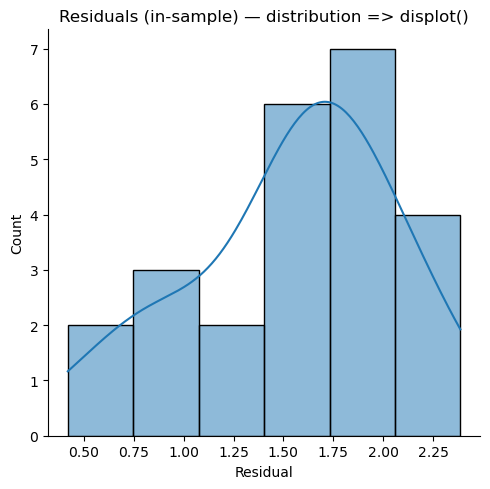

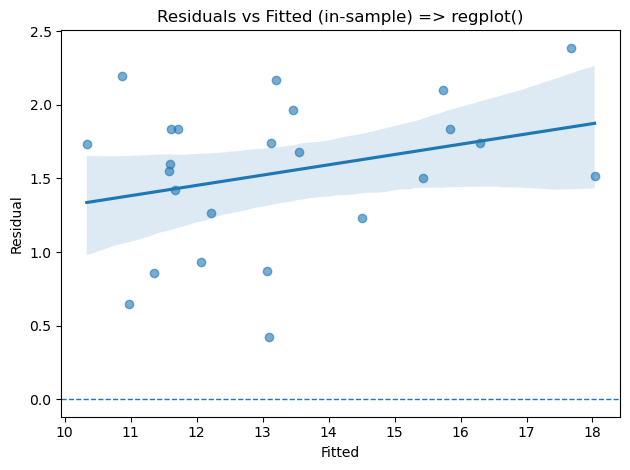

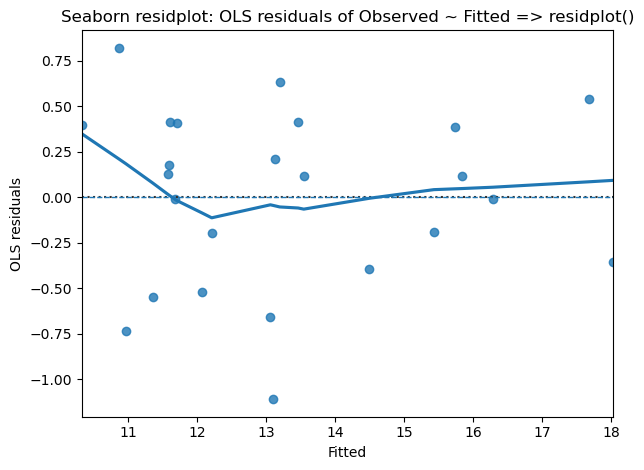

In [13]:
# 0) Fitted in-sample + résidus du Seasonal Naive (fallback si .predict_in_sample() absent)
try:
    fitted_in = forecasterSea.predict_in_sample()
except Exception:
    fitted_in = test.shift(12)
fitted_in.name = "Fitted (in-sample)"

# Aligner, supprimer NaN
common_idx = test.index.intersection(fitted_in.index)
y_obs  = test.loc[common_idx]
y_fit  = fitted_in.loc[common_idx]
resid  = (y_obs - y_fit)
resid.name = "Residuals (in-sample)"

# 1) Distribution des résidus — displot
sns.displot(resid, kde=True)
plt.title("Residuals (in-sample) — distribution => displot()")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# 2) Résidus vs valeurs ajustées — regplot (on cherche absence de structure)
sns.regplot(x=y_fit.values, y=resid.values, scatter_kws={"alpha":0.6})
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs Fitted (in-sample) => regplot()")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 3) Diagnostics type 'residplot'
# NOTE : seaborn.residplot affiche les résidus d'une régression OLS de y sur x.
# Ici on l'utilise comme check visuel supplémentaire : y_obs ~ y_fit.
sns.residplot(x=y_fit.values, y=y_obs.values, lowess=True)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Seaborn residplot: OLS residuals of Observed ~ Fitted => residplot()")
plt.xlabel("Fitted")
plt.ylabel("OLS residuals")
plt.tight_layout()
plt.show()


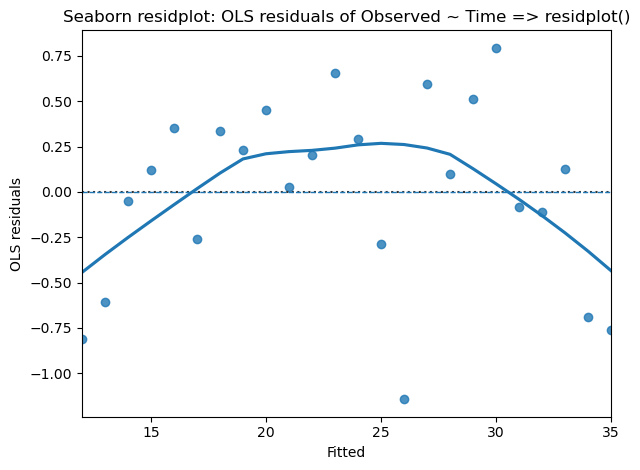

In [14]:


# 3Residplot() de Seasonal vs "le temps" => range(len(resid)) 

sns.residplot(x=np.array(range(len(resid))), y=resid.values, lowess=True)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Seaborn residplot: OLS residuals of Observed ~ Time => residplot()")
plt.xlabel("Fitted")
plt.ylabel("OLS residuals")
plt.tight_layout()
plt.show()


### 2.2 Error Metrics

You've probably already worked with the Mean Squared Error (MSE). Let's have a look at different metrics.

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

**TODO**
- Write a function to compute the MAPE
- Calculate the in-sample RMSE and MAPE for the last twelve months

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    mape = np.mean(np.abs((y_true - y_pred)/y_true)*100)
    return mape



def root_mean_square_error(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))
    return rmse

In [16]:
# Your code calculating the RMSE and MAPE for the Naive and Seasonal Naive models

mape=mean_absolute_percentage_error(test,TestPred)
rmse=root_mean_square_error(test,TestPred)

mapeSea=mean_absolute_percentage_error(test,TestPredSea)
rmseSea=root_mean_square_error(test,TestPredSea)

print(f'For the Naive model => Mape:{mape} and RMSE:{rmse}')

print(f'For the Seasonal Naive model => Mape:{mapeSea} and RMSE:{rmseSea}')

For the Naive model => Mape:20.953578466331987 and RMSE:4.056078003275859
For the Seasonal Naive model => Mape:13.113061222786992 and RMSE:2.3944057801603034


    On a une bien meilleure prédiction avec modèle Seasonal 

# 3. ARIMA Forecast

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over the options available in the core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember is that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formula for automatically selecting a good ARIMA forecasting model.

Even though modern applications tend to opt for the automatic approach for selecting the ARIMA parameters, we will have a go a trying and comparing how we perform with manual selection. As we discussed above, to train an ARIMA($p$,$d$,$q$) model we need to specify three parameters: $p$ (*AR*), $d$ (*I*) and $q$ (*MA*):
- To determine $p$, we look at the *direct* correlations, i.e. the *PACF*, and search for the lag $i$ such that $PACF_i \approx 0$
- To determine $q$, we look at the *full* correlations, i.e. the *ACF*, and search for the lag $i$ such that $ACF_i \approx 0$

Sometimes, we cannot apply directly these guidelines, and we must rely on a more detailed analysis or a grid search to determine the best $p,q$ for the problem at hand.

### Load the dataset & transform it

ARIMA models can take into account an increasing mean over time, but not the variance. Thus, a log transformation is enough for our purposes!

In [17]:
# Reload dataset from pmdarima
from pmdarima.datasets import load_airpassengers
from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

# Load dataset
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no DateTimeIndex from the bundled dataset. So let's add one.
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')

# Clean & Adjust data
airline_adj = airline / airline.index.days_in_month

# Train / Test split
train, test = ts_train_test_split(airline_adj, 12) ### 12 derniers mois => '1960-01-01'

# Apply log transformation
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

In [18]:
train_log.info() , test_log.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 132 entries, 1949-01-01 to 1959-12-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 12 entries, 1960-01-01 to 1960-12-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


(None, None)

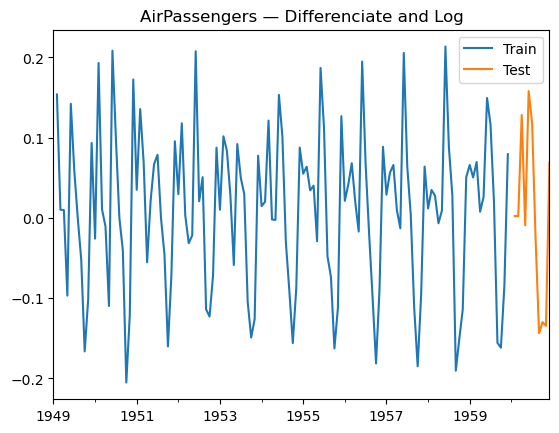

In [19]:
## On va différencier 

# Compare with Pandas
dfTrain = train_log.diff()
dfTest= test_log.diff()

dfTrain.plot(label="Train")
plt.title("AirPassengers — Differenciate and Log")
plt.xlim(1949,1960)
dfTest.plot(label="Test")
plt.legend()

plt.show()


In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [21]:
## Before transformation
adfB=adf_test(dfTrain[1:])
kpssB=kpss_test(dfTrain[1:])

print(f"Resuts : 1 differenciation is ok to have a stationary time-series")

Results of Dickey-Fuller Test:
Test Statistic                  -2.797928
p-value                          0.058570
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
Results of KPSS Test:
Test Statistic           0.023603
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Resuts : 1 differenciation is ok to have a stationary time-series


C:\Users\mvana\AppData\Local\Temp\ipykernel_27672\2441874341.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### 3.1 Estimate $p$, $d$ and $q$

**TODO**
- Based on the analysis done on the previous notebook, what would be a plausible value for $d$ ? => $d$ = 1 cf plus haut
- Plot the ACF and PACF and determine some plausible values for $p$ and $q$.
- Fit the ARIMA model and show the diagnostics using the `plot_diagnostics()` of pmdarima. Describe the different plots. How do you interpret these results ?

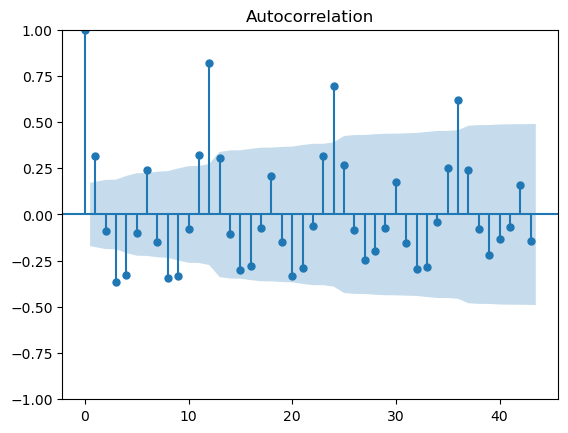

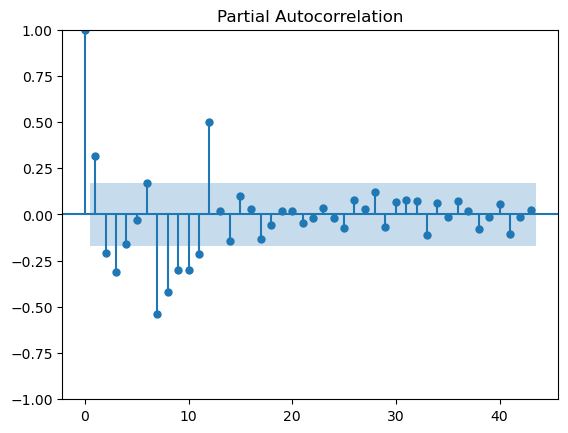

In [22]:
# Your code for the ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
ln=len(dfTrain[2:])-1
plot_acf(dfTrain[1:],lags=ln//3)
plt.show()

plot_pacf(dfTrain[1:],lags=ln//3)
plt.show()

`q` peut être estimé via l'ACF. On peut prendre les barres supérieurs aux écart-types => spoit `q`=1 ou 3 ou 4 

`p`peut être estimé via le PCAF => on pourrait croire qu'il peut être aux alentours de la valeur 12 car toutes les velurs sont après vers 0

In [23]:
# Your code for the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

p=12
d=1
q=3

arima = ARIMA(train_log, order=(p,d,q))
arima_fit = arima.fit()

c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
arima_values = arima_fit.forecast(steps=12)
arima_values

1960-01-01    2.626558
1960-02-01    2.669829
1960-03-01    2.705413
1960-04-01    2.717380
1960-05-01    2.752037
1960-06-01    2.896205
1960-07-01    3.000614
1960-08-01    3.010762
1960-09-01    2.869569
1960-10-01    2.707678
1960-11-01    2.627548
1960-12-01    2.699284
Freq: MS, Name: predicted_mean, dtype: float64

**TODO**
- Make a figure showing the train set, the test set, the predictions from ARIMA and the confidence intervals
- Make a second figure showing the predictions for the next 100 periods
- Calculate the RMSE and the MAPE on the test set

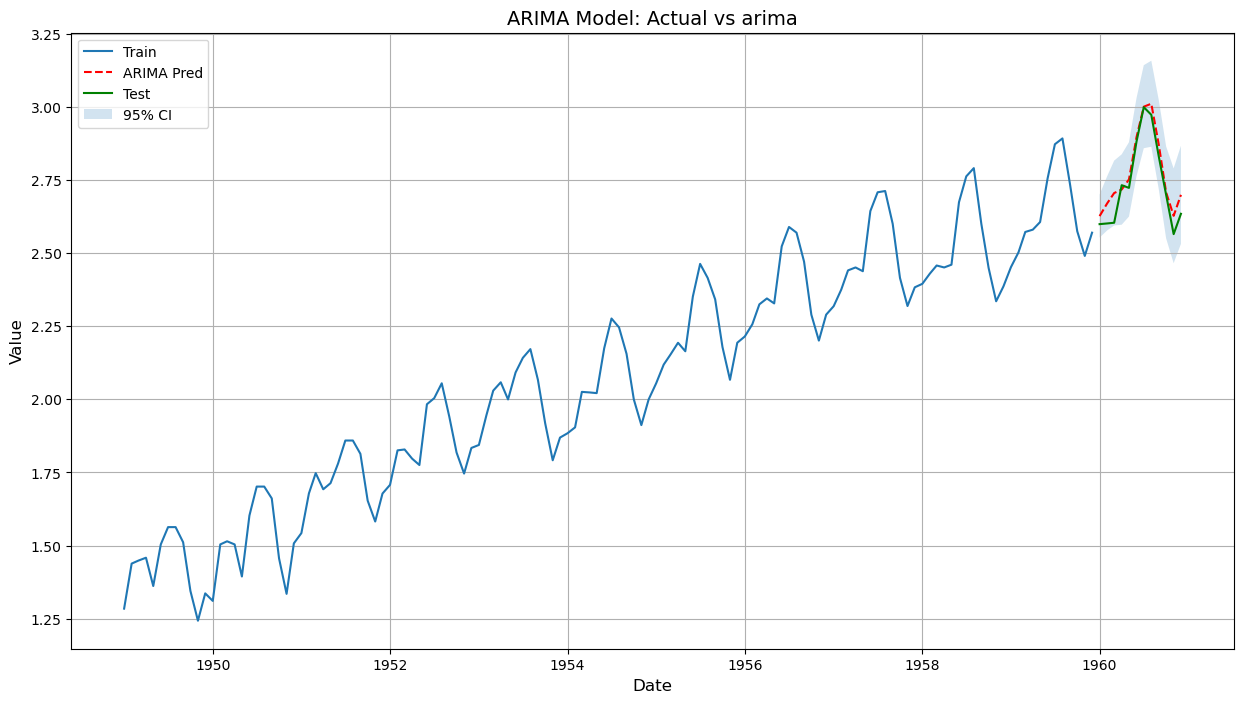

In [25]:
# Your code showing train, test, predictions and confidence interval
steps = 12
arima_values = arima_fit.get_forecast(steps=steps)
pred_mean_log = arima_values.predicted_mean
conf_int_log  = arima_values.conf_int(alpha=0.05)  # colonnes: lower, upper

pred_mean_log.index = pd.date_range(start=train_log.index[-1] + train_log.index.freq,
                                periods=steps, freq=train_log.index.freq)
conf_int_log.index = pred_mean_log.index


fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

plt.plot(train_log, label="Train")
plt.plot(pred_mean_log.index, pred_mean_log, label='ARIMA Pred', color='red', linestyle='--')
plt.plot(test_log,label="Test",color="green" )
ax.fill_between(pred_mean_log.index, conf_int_log.iloc[:, 0], conf_int_log.iloc[:, 1], alpha=0.2, label="95% CI")

plt.title('ARIMA Model: Actual vs arima', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

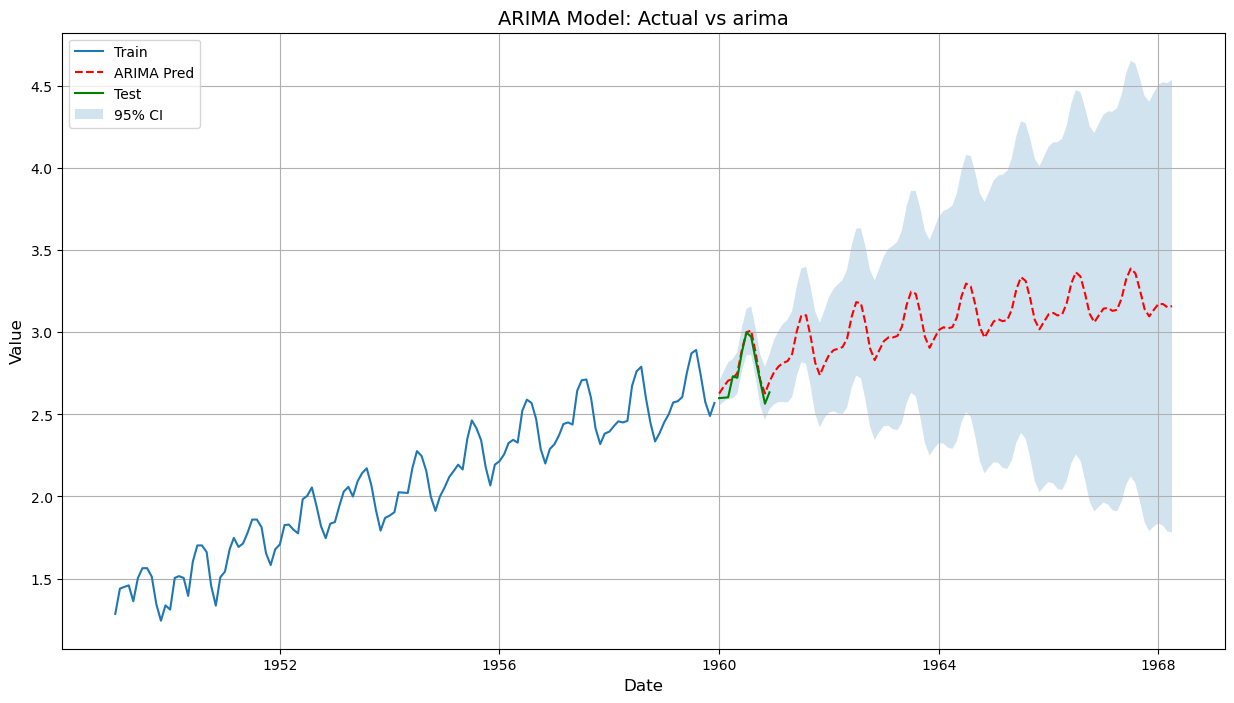

In [26]:
# Your code for showing the predictions for 100 periods
steps = 100
arima_values = arima_fit.get_forecast(steps=steps)
pred_mean_log = arima_values.predicted_mean
conf_int_log  = arima_values.conf_int(alpha=0.05)  # colonnes: lower, upper

pred_mean_log.index = pd.date_range(start=train_log.index[-1] + train_log.index.freq,
                                periods=steps, freq=train_log.index.freq)
conf_int_log.index = pred_mean_log.index


fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

plt.plot(train_log, label="Train")
plt.plot(pred_mean_log.index, pred_mean_log, label='ARIMA Pred', color='red', linestyle='--')
plt.plot(test_log,label="Test",color="green" )
ax.fill_between(pred_mean_log.index, conf_int_log.iloc[:, 0], conf_int_log.iloc[:, 1], alpha=0.2, label="95% CI")

plt.title('ARIMA Model: Actual vs arima', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


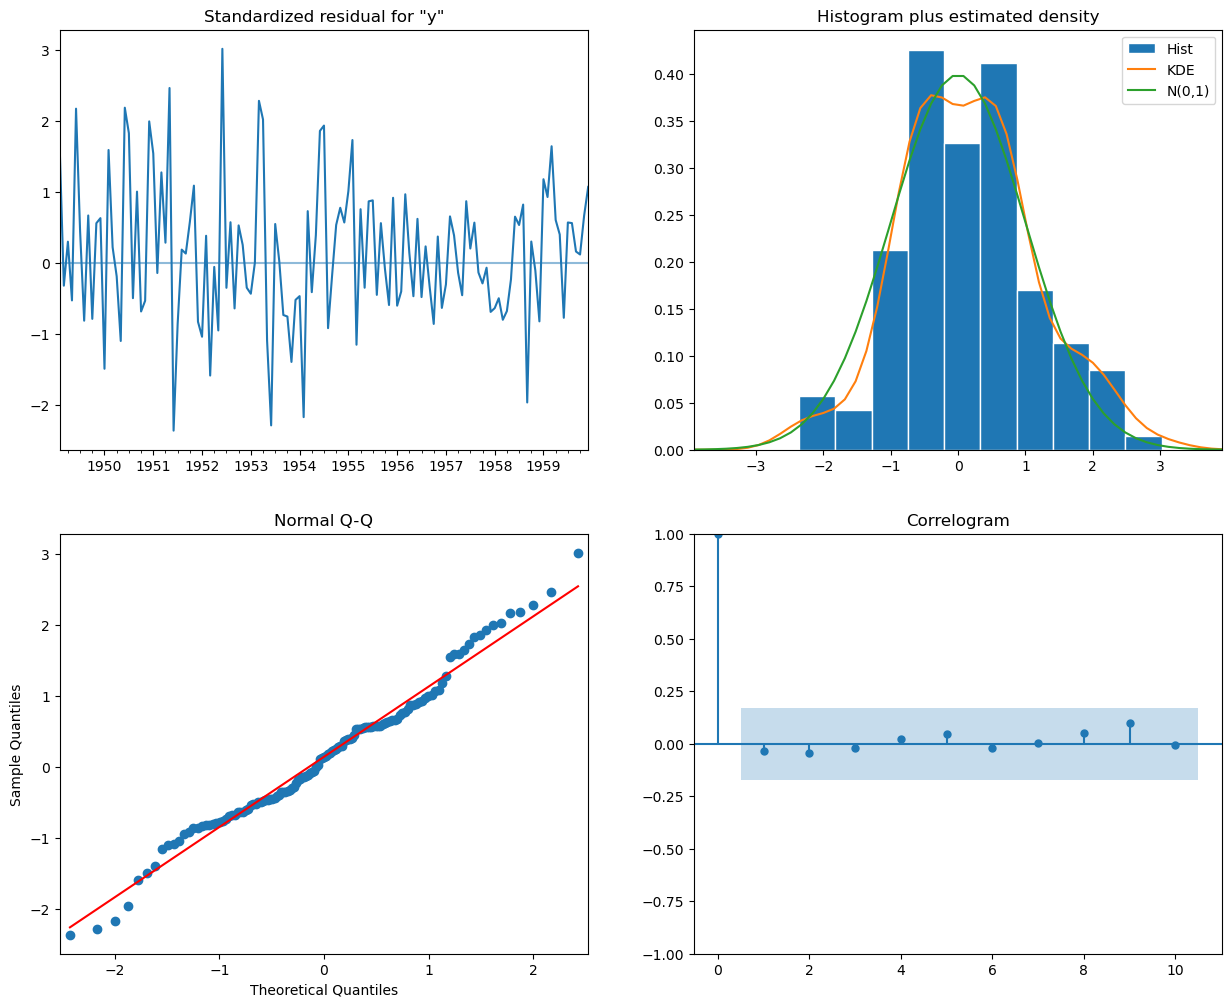

In [27]:
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error

# Your code calculating the RMSE and MAPE

mapeARIMA=np.exp(mean_absolute_percentage_error(test_log,pred_mean_log))
rmseARIMA=np.exp(root_mean_square_error(test_log,pred_mean_log))

print(f'For the Naive model => Mape:{mape} and RMSE:{rmse}')
print(f'For the Seasonal Naive model => Mape:{mapeSea} and RMSE:{rmseSea}')
print(f'For the ARIMA model => Mape:{mapeARIMA} and RMSE:{rmseARIMA}')

For the Naive model => Mape:20.953578466331987 and RMSE:4.056078003275859
For the Seasonal Naive model => Mape:13.113061222786992 and RMSE:2.3944057801603034
For the ARIMA model => Mape:4.364278476402274 and RMSE:1.049749504763095


Le model ARIMA prédit bien les données. On améliore grandement les erreurs de prédictions. 

**Conclusions**
- What are your conclusions ?
- What do you think about the error?

### 3.2 Seasonal ARIMA


As we have seen previously, ARMA models are well suited for stationary data. They may even works for data presenting seasonality, however seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

**Example** : Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of $p=12*12$ to comprehend seasonality of the problem!

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

The Seasonal ARIMA model, also known as SARIMA, is an extension of the basic ARIMA model that takes into account seasonality in the data. In a SARIMA model, we introduce additional seasonal components to the ARIMA model. The seasonal components mirror the ARIMA components but are applied to the seasonal patterns in the data. So, the SARIMA model has six additional parameters:

- Seasonal Autoregressive (SAR) component: This is similar to the AR component but for the seasonal patterns. It represents the relationship between the current value of the time series and its past values at the seasonal frequency.

- Seasonal Integrated (SI) component: This is similar to the I component but for the seasonal patterns. It involves differencing the time series at the seasonal frequency to achieve seasonality stationarity.

- Seasonal Moving Average (SMA) component: This is similar to the MA component but for the seasonal patterns. It models the relationship between the current value of the time series and past forecast errors at the seasonal frequency.

The seasonal frequency $s$ refers to the number of time periods that make up one seasonal cycle, and must also be provided to a SARIMA model. For example, if the time series exhibits a yearly seasonality, the seasonal frequency is 12 (assuming monthly data).

**TODO**
- Using a seasonal decomposition of the dataset, separate it into trend, seasonality and residual parts.
- Plot the moving mean and std of the trend and seasonal parts of the data.
- What can you conclude about stationarity of seasonal data? Can you then define $D$ and the seasonal frequency $s$ ?
- Does intra-seasonal data show specific seasonality ? What is $d$ (0, 1, or 2) ?
- Use the same procedure applied previously to a build a SARIMA model and evaluate its performance.

In [29]:
def moving_mean(x, n):
    return x.rolling(n).mean()

def moving_std(x, n):
    return x.rolling(n).std()

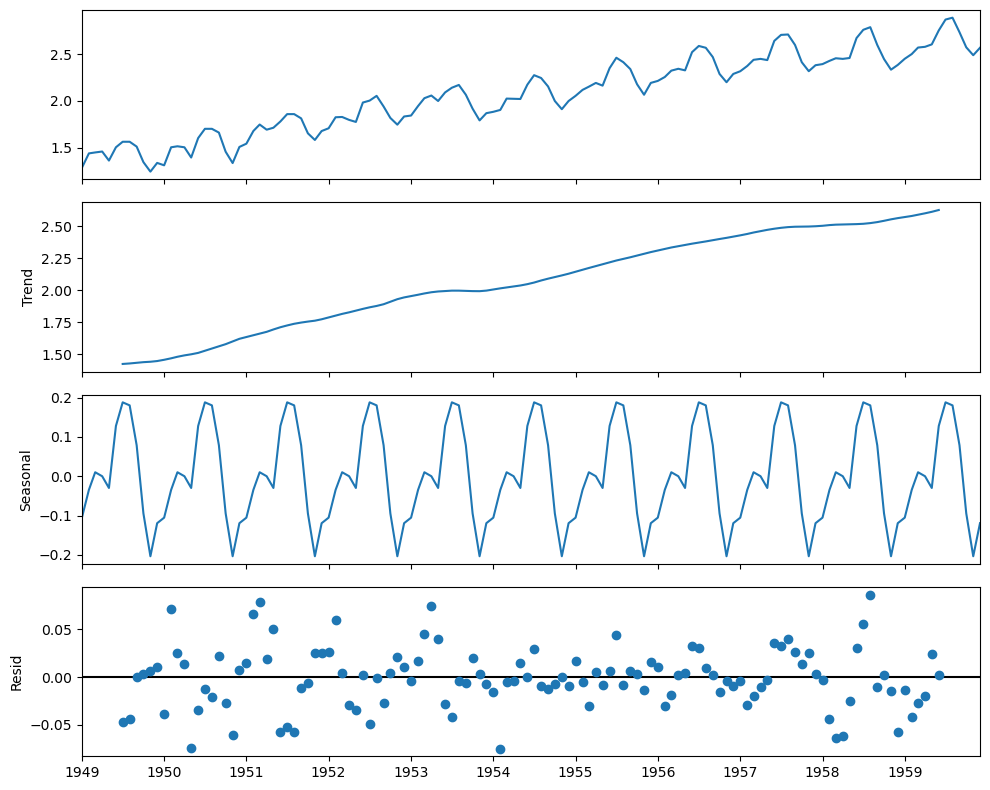

In [30]:
# Decompose the data into a trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive model
plt.rcParams['figure.figsize'] = 10, 8

result = seasonal_decompose(train_log, model='additive')
result.plot();


In [31]:
season=result.seasonal

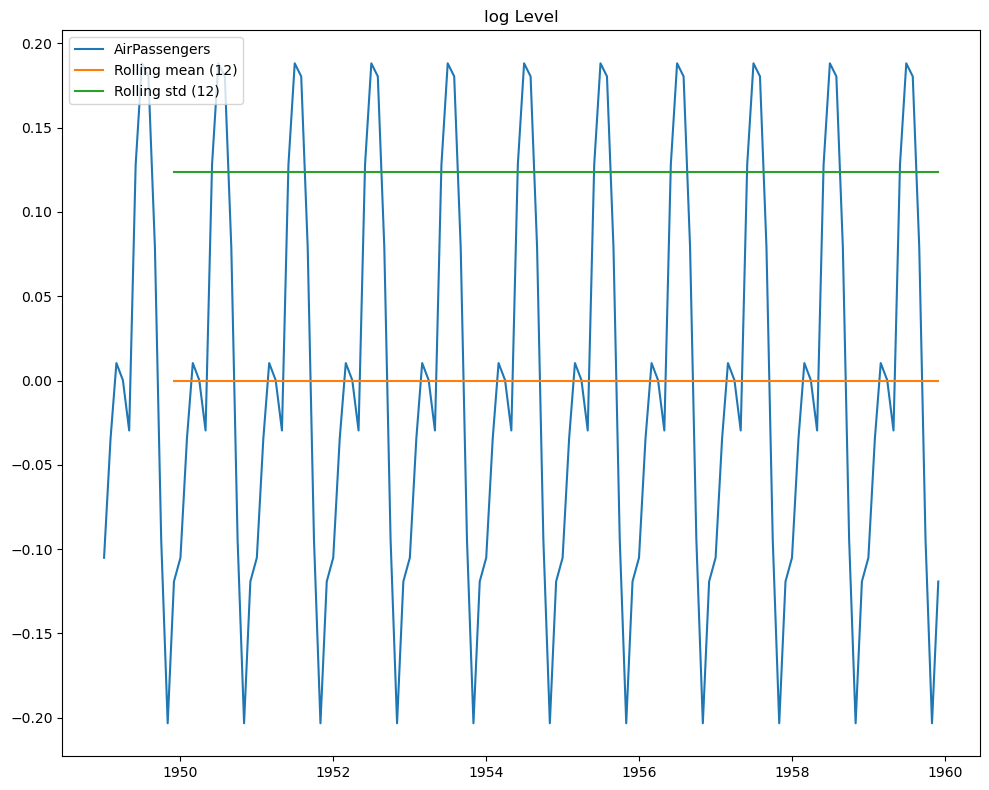

In [32]:
# Rolling mean & std (fenêtre 12 mois, centrée)
win = 12
rollMeanSea = moving_mean(season,win)
rollStdSea  = moving_std(season,win)

# Passengers (niveau)
plt.plot(season, label="AirPassengers")

# Rolling mean
plt.plot(rollMeanSea, label=f"Rolling mean ({win})")

# Rolling std
plt.plot(rollStdSea, label=f"Rolling std ({win})")

plt.title("log Level")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [33]:
# #### on est oblibé de différencier encore une fois, car rolling mean a tjrs une tendancce
# ## on va refaire le rolling sur le jeu de données différencié
# dfResult = seasonal_decompose(dfTrain[1:], model='additive')
# dfSea=dfResult.seasonal

# df_roll_mean = dfTrain.rolling(window=win, center=True).mean()
# df_roll_std  = dfTrain.rolling(window=win, center=True).std()

# # série, rolling mean, rolling std

# # Passengers (niveau)
# plt.plot(dfSea, label="AirPassengers")
# # Rolling mean
# plt.plot(df_roll_mean, label=f"Rolling mean ({win})")
# # Rolling std
# plt.plot(df_roll_std, label=f"Rolling std ({win})")

# plt.title("Diff and Log Level")
# plt.legend(loc="upper left")
# plt.tight_layout()
# plt.show()

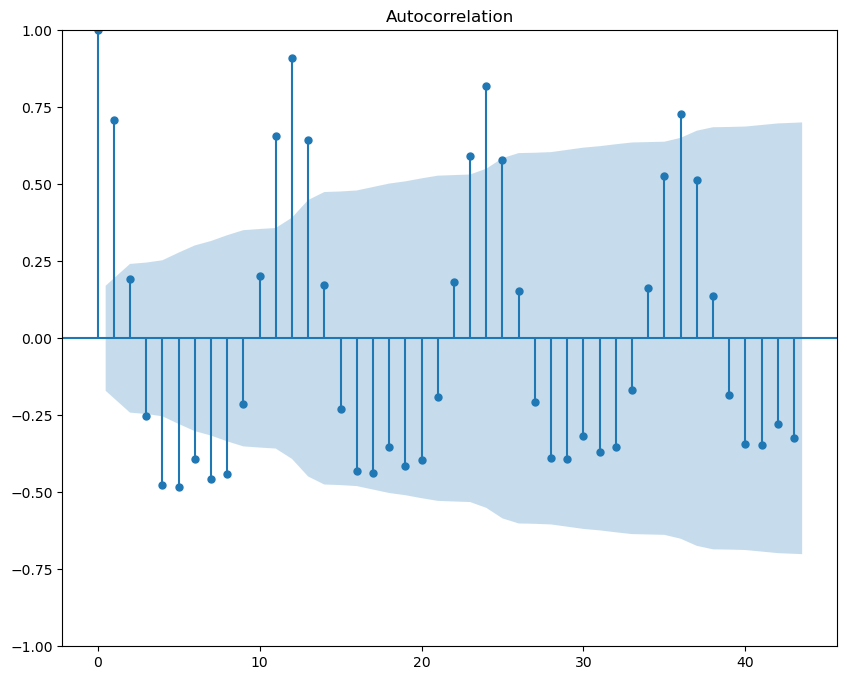

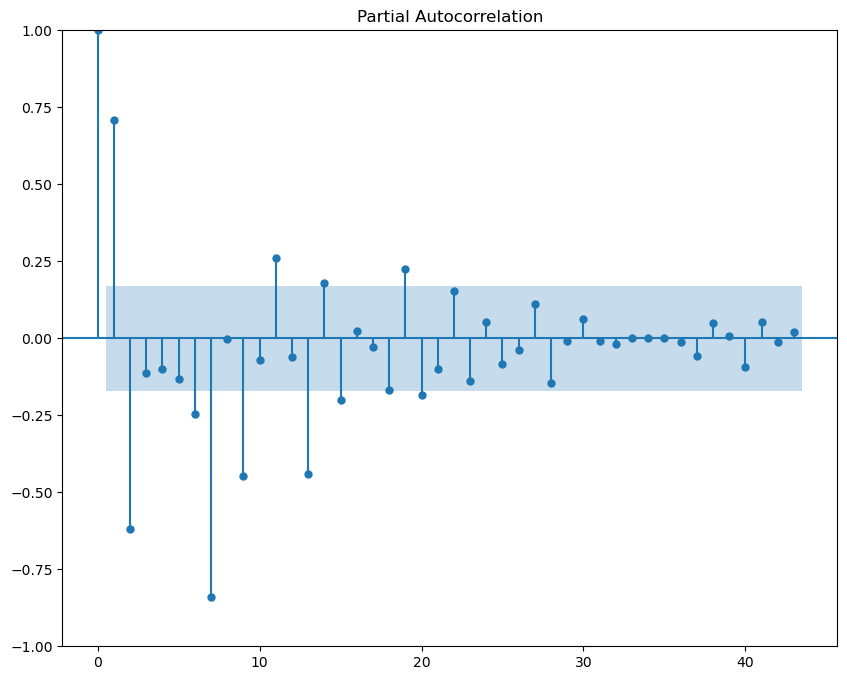

In [34]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the ACF and PACF
ln=len(season)-1
plot_acf(season,lags=ln//3)
plt.show()

plot_pacf(season,lags=ln//3)
plt.show()

On va prendre `q`de 4 et un `p`de 7

In [35]:
from statsmodels.tsa.arima.model import ARIMA


p=3
d=1
q=3

qs=1
ds=0
ps=2



sarima = ARIMA(train_log, order=(p,d,q), seasonal_order=(ps,ds,qs,win))
sarima_fit = sarima.fit()
print(sarima_fit.summary())

steps = 100
forecast_season = sarima_fit.get_forecast(steps=steps)

c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             ARIMA(3, 1, 3)x(2, 0, [1], 12)   Log Likelihood                 239.905
Date:                            Wed, 05 Nov 2025   AIC                           -459.809
Time:                                    15:23:48   BIC                           -431.057
Sample:                                01-01-1949   HQIC                          -448.126
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1464      0.318      0.460      0.645      -0.477       0.770
ar.L2         -0.1554      0.292   

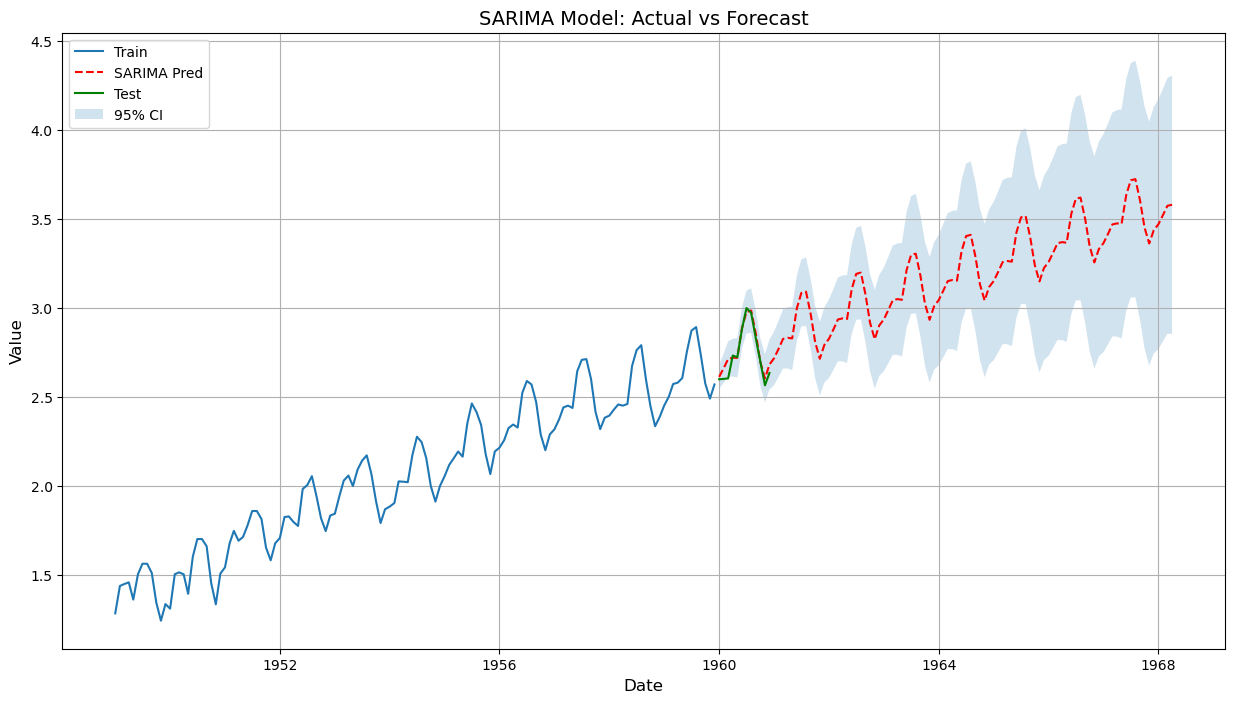

In [36]:
# Prévision sur 100 périodes hors-échantillon + IC à 95%
pred_mean_log = forecast_season.predicted_mean
conf_int_log  = forecast_season.conf_int(alpha=0.05)  # colonnes: lower, upper

# Show train, test, predictions and confidence interval

pred_mean_log.index = pd.date_range(start=train.index[-1] + train.index.freq,
                                periods=steps, freq=train.index.freq)
conf_int_log.index = pred_mean_log.index

# Your code for showing the predictions for 100 periods
# ci = 1.96 * np.std(forecast_season)/np.sqrt(len(forecast_season.index))

fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

plt.plot(train_log, label="Train")
plt.plot(pred_mean_log.index, pred_mean_log, label='SARIMA Pred', color='red', linestyle='--')
plt.plot(test_log,label="Test",color="green" )
# ax.fill_between(forecast_season.index, (forecast_season-ci), (forecast_season+ci), color='b', alpha=0.6)
ax.fill_between(pred_mean_log.index, conf_int_log.iloc[:, 0], conf_int_log.iloc[:, 1], alpha=0.2, label="95% CI")

plt.title('SARIMA Model: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


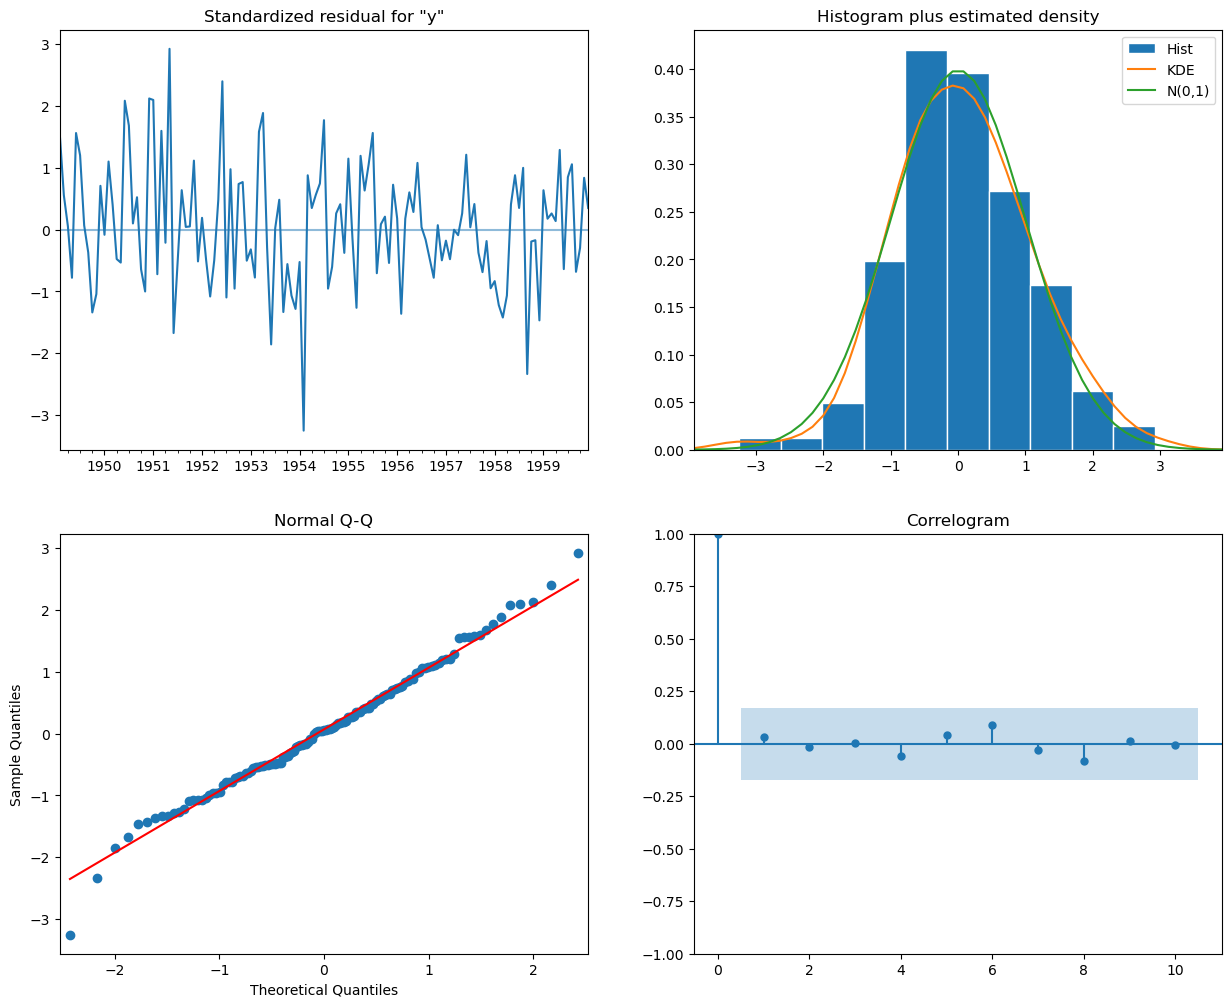

In [37]:
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
# Calculate the RMSE and the MAPE

# Your code here
mapeSARIMA=np.exp(mean_absolute_percentage_error(test_log,pred_mean_log))
rmseSARIMA=np.exp(root_mean_square_error(test_log,pred_mean_log))

print(f'For the Naive model => Mape:{mape} and RMSE:{rmse}')
print(f'For the Seasonal Naive model => Mape:{mapeSea} and RMSE:{rmseSea}')
print(f'For the ARIMA model => Mape:{mapeARIMA} and RMSE:{rmseARIMA}')
print(f'For the SARIMA model => Mape:{mapeSARIMA} and RMSE:{rmseSARIMA}')


For the Naive model => Mape:20.953578466331987 and RMSE:4.056078003275859
For the Seasonal Naive model => Mape:13.113061222786992 and RMSE:2.3944057801603034
For the ARIMA model => Mape:4.364278476402274 and RMSE:1.049749504763095
For the SARIMA model => Mape:3.04398020372899 and RMSE:1.042894714889938


**Conclusions**
- What are your conclusions with respect to the previous ARIMA model ?


On gagne encore plus de précison avec le modèle SARIMA
On peut essayer de gagner encore plus de performance en choisissant les meilleurs valeurs de q,p et d.

### 3.3 Auto-Arima  🎉

Auto ARIMA is an automated time series forecasting method that automatically selects the best combination of ARIMA model parameters ($p$, $d$, $q$) based on the data's characteristics. It uses algorithms to iteratively search and evaluate different models to find the most suitable one, saving users from manually tuning the parameters. Auto ARIMA is a powerful tool for efficiently forecasting time series data, especially when dealing with large datasets or when users have limited knowledge of time series modeling.

**TODO**
- Fit an `auto_arima` model and plot the diagnostics.
- How does it compare to the best model you found previously ?

In [39]:
from pmdarima.arima import auto_arima


autoArima=auto_arima(train_log,start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'e

 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-443.445, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-406.734, Time=0.03 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-443.351, Time=0.23 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-447.095, Time=0.71 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-416.233, Time=0.15 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-445.761, Time=0.73 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-445.738, Time=1.06 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-443.833, Time=0.32 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-443.793, Time=0.93 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-436.595, Time=0.24 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-445.030, Time=0.99 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-445.105, Time=0.56 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-447.012, Time=0.32 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-443.458, Time=1.06 sec


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-445.077, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 8.681 seconds


In [40]:
autoArima.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


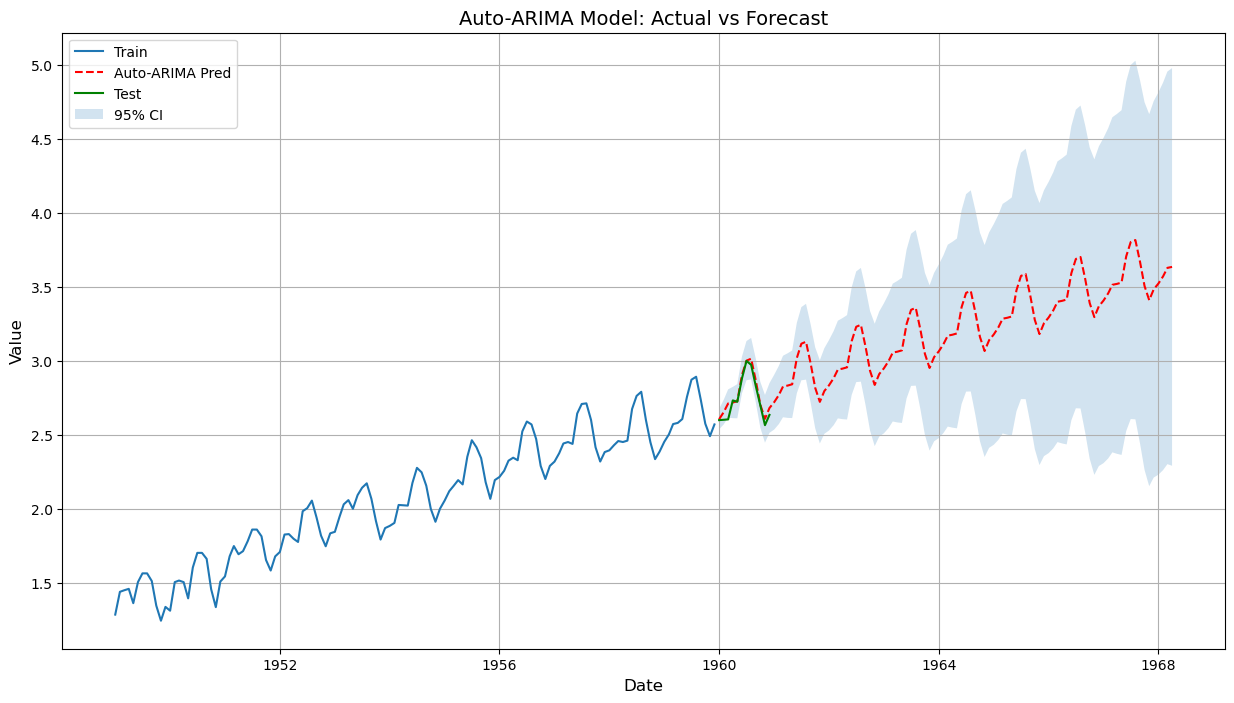

In [41]:
from statsmodels.tsa.arima.model import ARIMA


# p=3 d=1 q=3 pour ARIMA
# qs=3 ps=2 ds=1 pour SARIMA

## pour auto-ARIMA
pa=0
da=1
qa=1
s=12

steps = 100

autoArima=ARIMA(train_log,order=(pa,da,qa),seasonal_order=(pa,da,qa,s))
autoArima_fit=autoArima.fit()
forecast_auto= autoArima_fit.get_forecast(steps=steps)
pred_mean_log = forecast_auto.predicted_mean
conf_int_log  = forecast_auto.conf_int(alpha=0.05)  # colonnes: lower, upper

# Show train, test, predictions and confidence interval

pred_mean_log.index = pd.date_range(start=train.index[-1] + train.index.freq,
                                periods=steps, freq=train.index.freq)
conf_int_log.index = pred_mean_log.index


fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

plt.plot(train_log, label="Train")
plt.plot(pred_mean_log.index, pred_mean_log, label='Auto-ARIMA Pred', color='red', linestyle='--')
plt.plot(test_log,label="Test",color="green" )
# ax.fill_between(forecast_season.index, (forecast_season-ci), (forecast_season+ci), color='b', alpha=0.6)
ax.fill_between(pred_mean_log.index, conf_int_log.iloc[:, 0], conf_int_log.iloc[:, 1], alpha=0.2, label="95% CI")

plt.title('Auto-ARIMA Model: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# Your code here
mapeautoARIMA=np.exp(mean_absolute_percentage_error(test_log,pred_mean_log))
rmseautoARIMA=np.exp(root_mean_square_error(test_log,pred_mean_log))

print(f'For the Naive model => Mape:{mape} and RMSE:{rmse}')
print(f'For the Seasonal Naive model => Mape:{mapeSea} and RMSE:{rmseSea}')
print(f'For the ARIMA model => Mape:{mapeARIMA} and RMSE:{rmseARIMA}')
print(f'For the SARIMA model => Mape:{mapeSARIMA} and RMSE:{rmseSARIMA}')
print(f'For the Auto-ARIMA model => Mape:{mapeautoARIMA} and RMSE:{rmseautoARIMA}')


For the Naive model => Mape:20.953578466331987 and RMSE:4.056078003275859
For the Seasonal Naive model => Mape:13.113061222786992 and RMSE:2.3944057801603034
For the ARIMA model => Mape:4.364278476402274 and RMSE:1.049749504763095
For the SARIMA model => Mape:3.04398020372899 and RMSE:1.042894714889938
For the Auto-ARIMA model => Mape:3.266401758234601 and RMSE:1.0440278686243214


**Conclusions**
- How does `auto_arima` perform with respect to your previous models ? Can you explain why ?

Mon modèle Auto-Arima est un bon moins bon que mon modèle SARIMA

# 4. Cross-Validation

As you know, cross-validation is a crucial technique in the context of machine learning, designed to assess the predictive performance of these models and mitigate potential pitfalls associated with using limited data. Unlike traditional cross-validation used in other machine learning applications, time series cross-validation takes into account the temporal order of the data, ensuring that does not have any information from the future that it would not otherwise have at the time of making a forecast. 
By dividing the time series data into multiple subsets and iteratively validating the model's performance against unseen data, cross-validation provides valuable insights into how well the ARIMA model generalizes to different time periods. This rigorous evaluation will allow you to fine-tune model hyperparameters (such as ARIMA's parameters), assess forecast accuracy, and build more robust and reliable time series forecasting models.

In the classicial time series literature, time series cross validation is called a **Rolling Forecasting Horizon**. This is explained in details [here](https://robjhyndman.com/hyndsight/tscv/)

**TODO**
- Split the train data into a train and validation sets

In [43]:
train2,valid=ts_train_test_split(train_log,(len(train_log)/3)) # on découpe le jeu de données sur 50%
train2.info(), valid.info()

# Print the sizes to see if it's all good
ntrain= len(train2)*100/len(train_log)
nvalid=len(valid)*100/len(train_log)
print(f"length of Train: {round(ntrain,2)} % et length of Valid dataset: {round(nvalid,2)} %")
# Call time_series_cv

<class 'pandas.core.series.Series'>
DatetimeIndex: 88 entries, 1949-01-01 to 1956-04-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
88 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 44 entries, 1956-05-01 to 1959-12-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
44 non-null     float64
dtypes: float64(1)
memory usage: 704.0 bytes
length of Train: 66.67 % et length of Valid dataset: 33.33 %


### 4.1 Cross-Validation with Naive model

**TODO**
- Perform a cross-validation with the Seasonal Naive model you built previously

In [44]:
# Define the model

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series


# Define the length of time into the future for which forecasts are to be prepared
fhCross = ForecastingHorizon(valid.index, is_relative=False)

# Your code for the Naive Forecaster
forCross=NaiveForecaster(strategy="last",sp=12) ### ou strategy = "mean" ou "last"



In [45]:


# I've written a function to help with the cv of the baseline model
# THIS FUNCTION IS LOCATED IN THE ./forecast DIRECTORY, ALONG WITH THE NOTEBOOK
from forecast.model_selection import time_series_cv

# steps = 100
# forecast_season = sarima_fit.get_forecast(steps=steps)
horizon=(6,12,24,36)

# It requires the data to be split into train and validation
TScv=time_series_cv(forCross, mean_absolute_percentage_error, train2, valid, horizons=horizon, step=1)


# Show results
TScv=pd.DataFrame(TScv)
TScv.rename(columns={0: "H6", 1: "H12", 2: "H24", 3: "H36"})


,H6,H12,H24,H36
0,6.161682,5.604656,7.638293,9.052243
1,5.982713,5.368647,7.230284,8.732327
2,5.494923,5.159018,6.856791,8.358244
3,5.419901,5.113386,6.698099,8.218328
4,5.226198,5.042012,6.507836,8.008276
5,5.139066,5.018620,6.254391,7.831387
6,5.047630,5.053865,6.111083,7.737472
7,4.754582,4.960870,5.810602,7.541692
8,4.823112,4.936718,5.614211,7.507118


In [46]:
TScv.describe()


,0,1,2,3
count,9.000000,9.000000,9.000000,9.000000
mean,5.338868,5.139755,6.524621,8.109676
std,0.483129,0.216339,0.657804,0.531703
min,4.754582,4.936718,5.614211,7.507118
25%,5.047630,5.018620,6.111083,7.737472
50%,5.226198,5.053865,6.507836,8.008276
75%,5.494923,5.159018,6.856791,8.358244
max,6.161682,5.604656,7.638293,9.052243


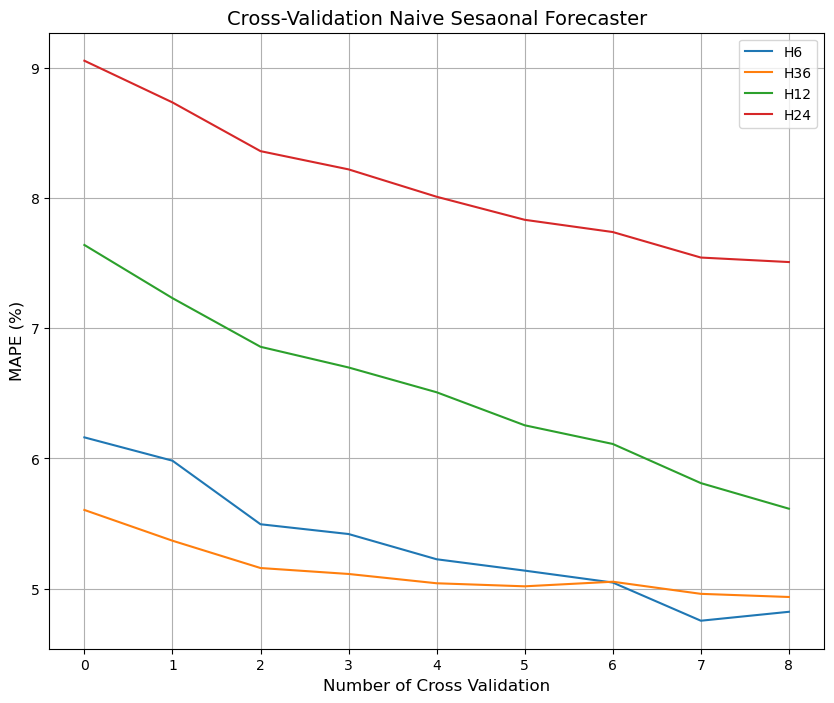

In [47]:
TScv.plot()
plt.title('Cross-Validation Naive Sesaonal Forecaster', fontsize=14)
plt.xlabel('Number of Cross Validation', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.legend(labels={"H6","H12", "H24","H36"})
plt.grid(True)
plt.show()


### 4.2 Cross-Validation with ARIMA

**TODO**
- Perform a cross-validation with your best ARIMA model. 
- Try different step values in the RollingForecastCV. What's the difference ?
- In each case, what's the size of the the data the model is trained on ?
- How many splits did we get ?

In [48]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

## pour auto-ARIMA
pa=0
da=1
qa=1
s=12

steps = 100

forecasterCV=ARIMA(order=(pa,da,qa),seasonal_order=(pa,da,qa,s))

horizons = [6, 12, 24, 36]
results = {}

for h in horizons:
    cv = RollingForecastCV(h=h, step=1)
    scores = cross_val_score(forecasterCV, y=train2, cv=cv,
                             scoring='mean_squared_error')
    results[h] = {
        "n_splits": len(scores),
        "mean_RMSE": np.mean(np.sqrt(scores)),
        "std_RMSE": np.std(np.sqrt(scores)),
        "scores": scores,        # tu peux inspecter le détail si besoin
    }
    print(f"h={h:>2} | splits={len(scores)} | MAPE mean={np.mean(scores):.4f} | std={np.std(scores):.4f}")

# Petit tableau récap
summary = pd.DataFrame({
    h: {"n_splits": v["n_splits"], "mean_RMSE": v["mean_RMSE"], "std_RMSE": v["std_RMSE"]}
    for h, v in results.items()
}).T.sort_index()

print("\nRésumé :")
print(summary)


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\sit

h= 6 | splits=54 | MAPE mean=0.0045 | std=0.0042


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mvana\anacon

h=12 | splits=48 | MAPE mean=0.0094 | std=0.0093


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mvana\anacon

h=24 | splits=36 | MAPE mean=0.0373 | std=0.0294


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mvana\anacon

h=36 | splits=24 | MAPE mean=0.1252 | std=0.1208

Résumé :
    n_splits  mean_RMSE  std_RMSE
6       54.0   0.059523  0.030490
12      48.0   0.086870  0.043600
24      36.0   0.179800  0.070316
36      24.0   0.321548  0.147502


c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [49]:
best_h = min(results, key=lambda h: results[h]["mean_RMSE"])
print(f"\nMeilleur horizon (MAPE moyenne la plus basse) : h={best_h}")


Meilleur horizon (MAPE moyenne la plus basse) : h=6


# 5. The Final Forecast

**TODO**
- Following the same methodology as above, produce your final forecast with your best model!
- Plot the predictions of the **Naive**, **Seasonal Naive**, and your best **SARIMA** model along with the test data, and compare they performances!

In [50]:
# Your code here
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline

from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

airline = load_airline().dropna()
airline_adj = airline / airline.index.days_in_month

airline_adj.index = airline_adj.index.to_timestamp()

ix = airline_adj.index.to_period()
# ix.to_timestamp(freq=airline_adj.index.freq)


train, test = ts_train_test_split(airline_adj, 36) #### split su 36 dernier mois (3 années)
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()



In [51]:

# 1) Convertir train/test au format attendu
def to_sf_df(s, uid="ap"):
    s = s.copy()
    # s doit avoir un DatetimeIndex régulier; je force MS pour éviter les soucis
    s.index = pd.DatetimeIndex(s.index).to_period("M").to_timestamp("M")
    return pd.DataFrame({
        "unique_id": uid,
        "ds": s.index,
        "y": s.values
    })

train_df = to_sf_df(train_log, uid="ap")
test_df  = to_sf_df(test_log,  uid="ap")   # utile pour la comparaison/plot


In [98]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

sf = StatsForecast(
    models=[SeasonalNaive(season_length=12)],
    freq="MS",
    n_jobs=-1
)
sf.fit(train_df)

# 3) Prédire h = nombre de pas à prévoir
h = 100                     # <— ENTIER
pred = sf.predict(h=h, level=[95])    # retourne un DataFrame
# colonnes typiques: ['unique_id', 'ds', 'SeasonalNaive', 'lo-70', 'hi-70']

# 4) Récupérer la série de prédiction et les IC
yhat = pred.set_index("ds")["SeasonalNaive"]
lo95 = pred.set_index("ds")["SeasonalNaive-lo-95"]
hi95 = pred.set_index("ds")["SeasonalNaive-hi-95"]


In [99]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.frequencies import to_offset

steps = 100

# code for the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

arimaBest=ARIMA(train_log,order=(0,1,1),seasonal_order=(0,1,1,6))
arimaBest_fit=arimaBest.fit()

# 2) Forecast
forecastBest = arimaBest_fit.get_forecast(steps=steps)

# 3) Construire un index futur solide (au cas où .freq est None)
freq = train_log.index.freq or train_log.index.inferred_freq
if freq is None:
    raise ValueError("La fréquence du DatetimeIndex n'est pas déduite. Spécifie-la ou fixe-la avant de prévoir.")
future_index = pd.date_range(
    start=train_log.index[-1] + to_offset(freq),
    periods=steps, freq=freq
)

# 4) Récupérer moyenne et intervalles + les indexer
pred_mean_log = pd.Series(forecastBest.predicted_mean, index=future_index)
conf_int_log  = forecastBest.conf_int()
conf_int_log.index = future_index



c:\Users\mvana\anaconda3\envs\DL_TimeEnv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


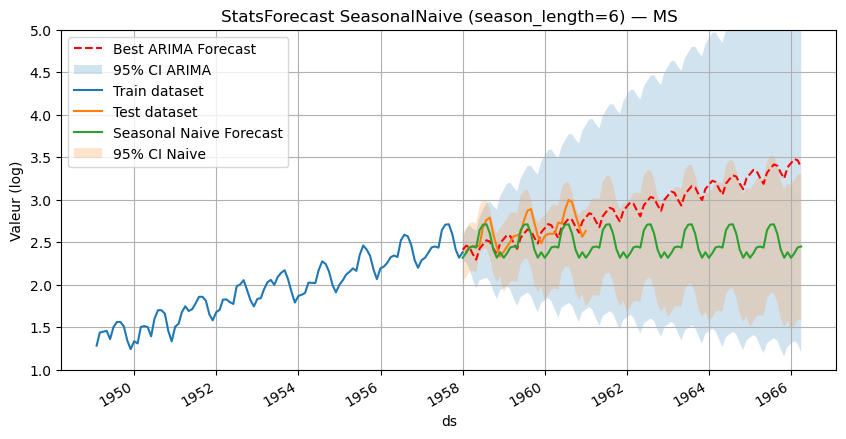

In [103]:
# 5) Plot propre sur UN seul axes
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(pred_mean_log.index, pred_mean_log, label="Best ARIMA Forecast",
        color="red", linestyle="--")

# fill_between a besoin de tableaux alignés
lower = conf_int_log.iloc[:, 0].to_numpy()
upper = conf_int_log.iloc[:, 1].to_numpy()
ax.fill_between(pred_mean_log.index, lower, upper, alpha=0.2, label="95% CI ARIMA")

ax.set_ylim(1, 5)
ax.set_title("Auto-ARIMA: Observations vs Prévision (log)")
ax.set_xlabel("Date")
ax.set_ylabel("Valeur (log)")
ax.grid(True)
ax.legend()

ax = train_df.set_index("ds")["y"].plot(label="Train dataset", figsize=(10,5))
test_df.set_index("ds")["y"].plot(ax=ax, label="Test dataset")
yhat.plot(ax=ax, label="Seasonal Naive Forecast")
plt.fill_between(yhat.index, lo95 , hi95, alpha=0.2, label="95% CI Naive")
plt.legend(); plt.title("StatsForecast SeasonalNaive (season_length=6) — MS")

plt.grid(True)
plt.show()



# Bonus

### B1. Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Have some time left ?** 
* Add a method `get_cv` Which performs cross validation
* To further automatize the process, add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit such as a log transformation.

In [ ]:
# Write your class here




### B2. Test this method on all the other [11 datasets] of pmdarima

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']

def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pm.datasets, 'load_'+ds_name)(as_series=True).dropna()
    
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    
    return ds.dropna()

### B3. Want some more ?

Choose your poison: https://data.world/datasets/time-series